# Investigacao de Dados Ausentes - Tarefcon x Paradas

Este notebook refatorado aprofunda a investigacao sobre combinacoes de dados ausentes na tabela de tarefas (tarefcon) e seus respectivos registros de parada.

Objetivos principais:
- padronizar a carga dos dados e o tratamento das tipagens;
- mapear proporcoes de ausencias nas principais chaves operacionais;
- cruzar ausencias com flags de parada e reprogramacao para identificar padroes;
- analisar as paradas relacionadas para entender possiveis causas operacionais.

In [7]:
pip install seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylin

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

sns.set_theme(style="whitegrid")

## 1. Carregamento e preparacao dos dados

In [4]:
DATA_DIR = Path('../../data/02 - trusted/parquet')

SENTINEL_INT = [-1]
SENTINEL_STR = ['-1', '-1.0']

In [17]:
df_tarefcon_raw = pd.read_parquet(DATA_DIR / 'tb_tarefcon.parquet')
df_paradas_raw = pd.read_parquet(DATA_DIR / 'tb_paradas.parquet')
lista_paradas = pd.read_csv('lista_cds_tarefcon.csv', dtype={'CD_CODIGOPARADAOUCONV': 'string'}).drop_duplicates('CD_CODIGOPARADAOUCONV')



In [35]:


def preparar_tarefcon(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    datetime_cols = ['DT_DIADATURMA', 'DT_INICIO', 'DT_FIM']
    for col in datetime_cols:
        if col in df.columns:
            df[col] = df[col].fillna('2999-01-01')
            df[col] = pd.to_datetime(df[col])

    id_cols = ['ID_PEDIDO', 'ID_ITEM', 'ID_IDCLIENTE', 'ID_USUARIO']
    for col in id_cols:
        if col in df.columns:
            df[col] = df[col].fillna('-1')

    numeric_cols = [
        'QT_CHAPASALIMENTADAS', 'QT_QUANTIDADEAJUSTE',
        'QT_QUANTIDADEPRODUZIDA', 'QT_QUANTIDADEPROGRAMADA'
    ]
    for col in numeric_cols:
        df[col] = df[col].fillna(int(0))
        if col in df.columns:
            df[col] = pd.to_numeric(df[col]).astype('Int64')

    float_cols = ['VL_ARRANJO', 'VL_DURACAOPREVISTA', 'VL_GRAMATURA','VL_DURACAO']
    for col in float_cols:
        df[col] = df[col].fillna(float(0))
        if col in df.columns:
            df[col] = pd.to_numeric(df[col])

    code_cols = ['CD_CODIGOPARADAOUCONV', 'CD_FACA', 'CD_OP', 'CD_OPONDULADA', 'CD_MAQUINA','CD_ORIGEMREGISTRO', 'CD_TURMA', 'TX_DESCORIGEMREGISTRO']
    for col in code_cols:
        if col in df.columns:
            df[col] = df[col].fillna('-1')


    bool_cols = ['FL_FLAGPARADA', 'FL_SKIPFEED', 'FL_REPROGRAMACAO']
    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].fillna(False)
            df[col] = df[col].replace({1: True, 0: False, '1': True, '0': False, 'True': True, 'False': False})
            df[col] = df[col].astype('boolean')

    return df

def preparar_paradas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    rename_map = {
        'TX_DESCRICAO': 'TX_DESCRICAO_PARADA',
        'FL_FLAGEXTERNA': 'FL_MOTIVO_EXTERNO_PARADA'
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    if 'CD_PARADA' in df.columns:
        df['CD_PARADA'] = df['CD_PARADA'].astype('string')
    if 'TX_DESCRICAO_PARADA' in df.columns:
        df['TX_DESCRICAO_PARADA'] = df['TX_DESCRICAO_PARADA'].astype('string')
    if 'FL_MOTIVO_EXTERNO_PARADA' in df.columns:
        df['FL_MOTIVO_EXTERNO_PARADA'] = df['FL_MOTIVO_EXTERNO_PARADA'].replace({1: True, 0: False, 'True': True, 'False': False}).astype('boolean')

    cols_to_drop = [c for c in ['FL_DESATIVADA', 'FL_USADACONVERSAO'] if c in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    return df

In [36]:
df_tarefcon = preparar_tarefcon(df_tarefcon_raw)
df_paradas = preparar_paradas(df_paradas_raw)
df_paradas_filtro = df_paradas[df_paradas['CD_PARADA'].isin(lista_paradas['CD_CODIGOPARADAOUCONV'])]

## 2. Visao geral do dataset

In [37]:
resumo_basico = pd.Series(dtype='object')
resumo_basico.loc['Total de registros'] = len(df_tarefcon)
if 'DT_DIADATURMA' in df_tarefcon.columns:
    inicio = df_tarefcon['DT_DIADATURMA'].min()
    fim = df_tarefcon['DT_DIADATURMA'].max()
    if pd.notna(inicio) and pd.notna(fim):
        resumo_basico.loc['Periodo (DT_DIADATURMA)'] = f"{inicio:%Y-%m-%d} -> {fim:%Y-%m-%d}"
if 'FL_FLAGPARADA' in df_tarefcon.columns:
    resumo_basico.loc['Registros com parada'] = int(df_tarefcon['FL_FLAGPARADA'].fillna(False).sum())
if 'FL_REPROGRAMACAO' in df_tarefcon.columns:
    resumo_basico.loc['Registros com reprogramacao'] = int(df_tarefcon['FL_REPROGRAMACAO'].fillna(False).sum())

display(resumo_basico.to_frame(name='valor'))

,valor
Total de registros,1604562
Periodo (DT_DIADATURMA),2021-12-27 -> 2025-09-24
Registros com parada,1284911
Registros com reprogramacao,312919


In [38]:
resumo_basico = pd.Series(dtype='object')
resumo_basico.loc['Total de registros'] = len(df_tarefcon)
if 'DT_DIADATURMA' in df_tarefcon.columns:
    inicio = df_tarefcon['DT_DIADATURMA'].min()
    fim = df_tarefcon['DT_DIADATURMA'].max()
    if pd.notna(inicio) and pd.notna(fim):
        resumo_basico.loc['Periodo (DT_DIADATURMA)'] = f"{inicio:%Y-%m-%d} -> {fim:%Y-%m-%d}"
if 'FL_FLAGPARADA' in df_tarefcon.columns:
    resumo_basico.loc['Registros com parada'] = int(df_tarefcon['FL_FLAGPARADA'].fillna(False).sum())
if 'FL_REPROGRAMACAO' in df_tarefcon.columns:
    resumo_basico.loc['Registros com reprogramacao'] = int(df_tarefcon['FL_REPROGRAMACAO'].fillna(False).sum())

display(resumo_basico.to_frame(name='valor'))

,valor
Total de registros,1604562
Periodo (DT_DIADATURMA),2021-12-27 -> 2025-09-24
Registros com parada,1284911
Registros com reprogramacao,312919


In [40]:
df_tarefcon.sort_values(by='ID_PEDIDO')

,CD_MAQUINA,FL_FLAGPARADA,CD_CODIGOPARADAOUCONV,CD_TURMA,CD_OP,ID_PEDIDO,ID_ITEM,FL_REPROGRAMACAO,VL_ARRANJO,VL_GRAMATURA,QT_QUANTIDADEPROGRAMADA,QT_CHAPASALIMENTADAS,QT_QUANTIDADEPRODUZIDA,QT_QUANTIDADEAJUSTE,VL_DURACAOPREVISTA,DT_INICIO,DT_FIM,DT_DIADATURMA,ID_IDCLIENTE,ID_USUARIO,CD_ORIGEMREGISTRO,TX_DESCORIGEMREGISTRO,FL_SKIPFEED,CD_OPONDULADA,VL_DURACAO,CD_FACA
802280,MID1,True,1.0,A,-1,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2022-03-02,2022-03-02,2022-03-02,-1,223.0,1.0,Online CLP,False,-1,15,-1
1005415,MINI1,True,130.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,2,-1
1005414,MINI1,True,114.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,10,-1
1005413,MINI1,True,107.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,40,-1
1005412,MINI1,True,1.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114592,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,6700,6700,6700,0,795.00,2025-08-05,2025-08-05,2025-08-05,1757.0,976.0,0.0,Manual padrão,False,-1,270,-1
1132515,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,9600,9600,9600,0,"1,282.00",2025-07-19,2025-07-19,2025-07-19,1757.0,976.0,0.0,Manual padrão,False,-1,350,-1
1112047,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,1850,1850,1850,0,"1,343.00",2025-07-16,2025-07-16,2025-07-16,1757.0,976.0,0.0,Manual padrão,False,-1,60,-1
1116068,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,9000,9000,9000,0,795.00,2025-08-02,2025-08-02,2025-08-02,1757.0,976.0,0.0,Manual padrão,False,-1,130,-1


In [41]:
df_tarefcon.sort_values(by='ID_PEDIDO')

,CD_MAQUINA,FL_FLAGPARADA,CD_CODIGOPARADAOUCONV,CD_TURMA,CD_OP,ID_PEDIDO,ID_ITEM,FL_REPROGRAMACAO,VL_ARRANJO,VL_GRAMATURA,QT_QUANTIDADEPROGRAMADA,QT_CHAPASALIMENTADAS,QT_QUANTIDADEPRODUZIDA,QT_QUANTIDADEAJUSTE,VL_DURACAOPREVISTA,DT_INICIO,DT_FIM,DT_DIADATURMA,ID_IDCLIENTE,ID_USUARIO,CD_ORIGEMREGISTRO,TX_DESCORIGEMREGISTRO,FL_SKIPFEED,CD_OPONDULADA,VL_DURACAO,CD_FACA
802280,MID1,True,1.0,A,-1,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2022-03-02,2022-03-02,2022-03-02,-1,223.0,1.0,Online CLP,False,-1,15,-1
1005415,MINI1,True,130.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,2,-1
1005414,MINI1,True,114.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,10,-1
1005413,MINI1,True,107.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,40,-1
1005412,MINI1,True,1.0,A,684303-3/801050,-1,-1,False,0.00,0.00,0,0,0,0,0.00,2024-11-24,2024-11-24,2024-11-24,-1,223.0,1.0,Online CLP,False,-1,10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114592,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,6700,6700,6700,0,795.00,2025-08-05,2025-08-05,2025-08-05,1757.0,976.0,0.0,Manual padrão,False,-1,270,-1
1132515,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,9600,9600,9600,0,"1,282.00",2025-07-19,2025-07-19,2025-07-19,1757.0,976.0,0.0,Manual padrão,False,-1,350,-1
1112047,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,1850,1850,1850,0,"1,343.00",2025-07-16,2025-07-16,2025-07-16,1757.0,976.0,0.0,Manual padrão,False,-1,60,-1
1116068,VINC2,False,-1,A,REP021988/606500,REP021988,606500,True,1.00,369.00,9000,9000,9000,0,795.00,2025-08-02,2025-08-02,2025-08-02,1757.0,976.0,0.0,Manual padrão,False,-1,130,-1


## 3. Panorama de completude

In [42]:
colunas_foco = [
    'ID_PEDIDO', 'ID_ITEM', 'ID_IDCLIENTE', 'CD_CODIGOPARADAOUCONV',
    'CD_OP', 'CD_OPONDULADA', 'CD_FACA', 'ID_USUARIO'
]
colunas_foco = [c for c in colunas_foco if c in df_tarefcon.columns]

missing_counts = df_tarefcon[colunas_foco].isna().sum().rename('registros_ausentes')
missing_pct = (df_tarefcon[colunas_foco].isna().mean() * 100).round(2).rename('perc_ausencia')
missing_dtype = df_tarefcon[colunas_foco].dtypes.astype(str).rename('dtype')

missing_summary = pd.concat([missing_counts, missing_pct, missing_dtype], axis=1).sort_values('perc_ausencia', ascending=False)
display(missing_summary)

,registros_ausentes,perc_ausencia,dtype
ID_PEDIDO,0,0.00,string
ID_ITEM,0,0.00,string
ID_IDCLIENTE,0,0.00,string
CD_CODIGOPARADAOUCONV,0,0.00,string
CD_OP,0,0.00,string
CD_OPONDULADA,0,0.00,string
CD_FACA,0,0.00,string
ID_USUARIO,0,0.00,string


C:\Users\norris\AppData\Local\Temp\ipykernel_10108\558507542.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x='perc_ausencia', y='coluna', palette='Blues_r', ax=ax)


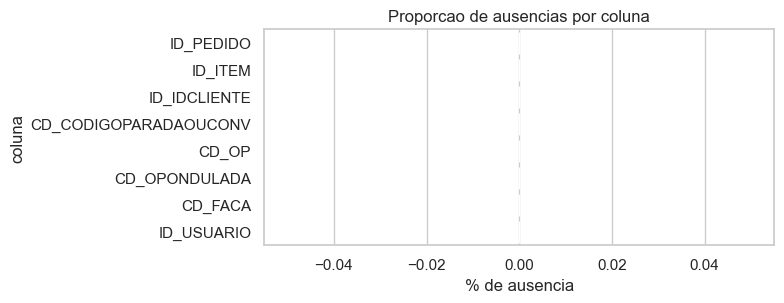

In [43]:
if not missing_summary.empty:
    plot_data = missing_summary.reset_index().rename(columns={'index': 'coluna'})
    fig, ax = plt.subplots(figsize=(8, max(3, len(plot_data) * 0.4)))
    sns.barplot(data=plot_data, x='perc_ausencia', y='coluna', palette='Blues_r', ax=ax)
    ax.set_xlabel('% de ausencia')
    ax.set_ylabel('coluna')
    ax.set_title('Proporcao de ausencias por coluna')
    plt.tight_layout()
    plt.show()

### 3.1 Combinacoes de ausencias e flags operacionais

In [44]:
analysis = df_tarefcon.copy()
analysis['missing_pedido'] = analysis['ID_PEDIDO'].isna() if 'ID_PEDIDO' in analysis.columns else False
analysis['missing_item'] = analysis['ID_ITEM'].isna() if 'ID_ITEM' in analysis.columns else False
analysis['missing_cliente'] = analysis['ID_IDCLIENTE'].isna() if 'ID_IDCLIENTE' in analysis.columns else False
analysis['missing_op'] = analysis['CD_OP'].isna() if 'CD_OP' in analysis.columns else False
analysis['missing_cod_parada'] = analysis['CD_CODIGOPARADAOUCONV'].isna() if 'CD_CODIGOPARADAOUCONV' in analysis.columns else False
analysis['is_parada'] = analysis['FL_FLAGPARADA'].fillna(False) if 'FL_FLAGPARADA' in analysis.columns else False
analysis['is_reprogramacao'] = analysis['FL_REPROGRAMACAO'].fillna(False) if 'FL_REPROGRAMACAO' in analysis.columns else False

combo_cols = ['missing_pedido', 'missing_item', 'missing_cliente', 'is_parada', 'is_reprogramacao']
combo_summary = (
    analysis
    .groupby(combo_cols, dropna=False)
    .size()
    .rename('registros')
    .reset_index()
    .assign(percentual=lambda d: (d['registros'] / len(analysis) * 100).round(2))
    .sort_values('registros', ascending=False)
)
display(combo_summary.head(10))

,missing_pedido,missing_item,missing_cliente,is_parada,is_reprogramacao,registros,percentual
2,False,False,False,True,False,1284911,80.08
1,False,False,False,False,True,312919,19.50
0,False,False,False,False,False,6732,0.42


A tabela acima destaca os agrupamentos mais frequentes entre ausencias de IDs e os status operacionais.
Verifique se os padroes encontrados anteriormente (ID_PEDIDO ausente ocorrendo junto com parada e reprogramacao) permanecem consistentes.

### 3.2 Foco nos registros sem ID_PEDIDO

In [ ]:
missing_pedido = analysis[analysis['missing_pedido']]
total_missing_pedido = len(missing_pedido)

if total_missing_pedido > 0:
    resumo_missing_pedido = pd.Series({
        'Registros com ID_PEDIDO ausente': total_missing_pedido,
        '% do dataset': round(total_missing_pedido / len(analysis) * 100, 2),
        'Com ID_ITEM preenchido': int((~missing_pedido['missing_item']).sum()),
        '% com ID_ITEM preenchido': round((~missing_pedido['missing_item']).mean() * 100, 2),
        'Com ID_IDCLIENTE preenchido': int((~missing_pedido['missing_cliente']).sum()),
        '% com ID_IDCLIENTE preenchido': round((~missing_pedido['missing_cliente']).mean() * 100, 2),
        'Com parada (FL_FLAGPARADA)': int(missing_pedido['is_parada'].sum()),
        '% com parada': round(missing_pedido['is_parada'].mean() * 100, 2),
        'Com reprogramacao (FL_REPROGRAMACAO)': int(missing_pedido['is_reprogramacao'].sum()),
        '% com reprogramacao': round(missing_pedido['is_reprogramacao'].mean() * 100, 2)
    })
    display(resumo_missing_pedido.to_frame(name='valor'))

    cruzamento_cliente = (
        missing_pedido
        .assign(cliente_preenchido=~missing_pedido['missing_cliente'])
        .groupby(['cliente_preenchido', 'is_parada', 'is_reprogramacao'])
        .size()
        .rename('registros')
        .reset_index()
        .assign(percentual=lambda d: (d['registros'] / total_missing_pedido * 100).round(2))
        .sort_values('registros', ascending=False)
    )
    display(cruzamento_cliente)
else:
    print('Nenhum registro com ID_PEDIDO ausente foi encontrado.')

### 3.3 Evolucao temporal do ID_PEDIDO ausente

In [ ]:
if 'DT_DIADATURMA' in analysis.columns and not analysis['DT_DIADATURMA'].isna().all():
    timeline_total = (
        analysis
        .assign(periodo=lambda d: d['DT_DIADATURMA'].dt.to_period('M'))
        .groupby('periodo')
        .size()
        .rename('total')
    )
    timeline_missing = (
        missing_pedido
        .assign(periodo=lambda d: d['DT_DIADATURMA'].dt.to_period('M'))
        .groupby('periodo')
        .size()
        .rename('missing')
    )
    timeline = (
        pd.concat([timeline_total, timeline_missing], axis=1)
        .fillna(0)
        .assign(share=lambda d: (d['missing'] / d['total'] * 100).round(2))
        .reset_index()
        .sort_values('periodo')
    )
    display(timeline.tail(12))

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(timeline['periodo'].astype(str), timeline['share'], marker='o')
    ax.set_ylabel('% de registros com ID_PEDIDO ausente')
    ax.set_xlabel('Periodo (mes)')
    ax.set_title('Proporcao mensal de registros sem ID_PEDIDO')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Coluna DT_DIADATURMA indisponivel ou totalmente ausente.')

## 4. Relacao com as paradas

In [ ]:
paradas_lookup_cols = [c for c in ['CD_PARADA', 'TX_DESCRICAO_PARADA', 'FL_MOTIVO_EXTERNO_PARADA'] if c in df_paradas_filtro.columns]
paradas_lookup = df_paradas_filtro[paradas_lookup_cols].drop_duplicates('CD_PARADA') if paradas_lookup_cols else pd.DataFrame()

if not paradas_lookup.empty and 'CD_CODIGOPARADAOUCONV' in analysis.columns:
    analysis = analysis.merge(paradas_lookup, how='left', left_on='CD_CODIGOPARADAOUCONV', right_on='CD_PARADA')
    paradas_missing = analysis[analysis['missing_pedido'] & analysis['is_parada']]
    if not paradas_missing.empty:
        causas_top = (
            paradas_missing['TX_DESCRICAO_PARADA']
            .fillna('Sem descricao')
            .value_counts()
            .head(10)
            .rename_axis('TX_DESCRICAO_PARADA')
            .reset_index(name='registros')
        )
        causas_top['percentual'] = (causas_top['registros'] / len(paradas_missing) * 100).round(2)
        display(causas_top)

        motivos_externos = (
            paradas_missing['FL_MOTIVO_EXTERNO_PARADA']
            .value_counts(dropna=False)
            .rename_axis('FL_MOTIVO_EXTERNO_PARADA')
            .reset_index(name='registros')
        )
        motivos_externos['percentual'] = (motivos_externos['registros'] / len(paradas_missing) * 100).round(2)
        display(motivos_externos)
    else:
        print('Nao ha registros de parada com ID_PEDIDO ausente para analisar.')
else:
    print('Tabela de paradas indisponivel ou sem colunas-chave.')

## 5. Leituras finais e proximos passos

- Utilize as tabelas de combinacoes para confirmar os percentuais de registros sem ID_PEDIDO em relacao a parada e reprogramacao.
- Avalie a evolucao temporal para identificar periodos com aumento abrupto de ausencias.
- Observe as descricoes de parada que concentram tarefas sem ID_PEDIDO; elas podem direcionar ajustes operacionais ou regras de negocio.
- Se necessario, complemente com filtros adicionais (maquina, cliente, item) para mapear focos especificos.

> Observacao: os achados anteriores apontavam que a combinacao de ID_PEDIDO, ID_ITEM e ID_IDCLIENTE ausentes ocorre quase sempre com FL_FLAGPARADA = True e alta incidencia de reprogramacao. Execute as celulas acima para validar se o comportamento permanece no periodo analisado.